In [3]:
# ==========================================
# 1. IMPORTAÇÃO DE BIBLIOTECAS
# ==========================================
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import random
import re
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração visual padrão para os gráficos
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore') # Oculta avisos desnecessários do Pandas

In [4]:
# ==========================================
# 2. WEB SCRAPING (COLETA DE DADOS BRUTOS)
# ==========================================

def obter_html(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    print(f"A descarregar dados de: {url}")
    resposta = requests.get(url, headers=headers)
    time.sleep(random.uniform(2, 4)) 
    return resposta.text if resposta.status_code == 200 else None

def extrair_partidas(html):
    soup = BeautifulSoup(html, 'html.parser')
    partidas = []
    data_atual, horario_atual = None, None
    
    for box in soup.find_all('div', class_='box'):
        for linha in box.find_all('tr'):
            colunas = linha.find_all('td')
            if len(colunas) >= 7: 
                try:
                    texto_data = colunas[0].text.strip()
                    if texto_data: data_atual = texto_data
                        
                    texto_horario = colunas[1].text.strip()
                    if texto_horario: horario_atual = texto_horario
                        
                    time_casa = colunas[2].text.strip()
                    resultado = colunas[4].text.strip()
                    time_visitante = colunas[6].text.strip()
                    
                    if time_casa and time_visitante:
                        partidas.append({
                            'Data': data_atual,
                            'Horario': horario_atual,
                            'Time_Casa_Raw': time_casa,
                            'Resultado': resultado,
                            'Time_Visitante_Raw': time_visitante
                        })
                except:
                    continue
    return partidas

# Execução da Extração
url_alvo = "https://www.transfermarkt.com.br/campeonato-brasileiro-serie-a/gesamtspielplan/wettbewerb/BRA1?saison_id=2024&spieltagVon=1&spieltagBis=38"
html_puro = obter_html(url_alvo)

if html_puro:
    df_jogos = pd.DataFrame(extrair_partidas(html_puro))
    print(f"Sucesso! {len(df_jogos)} jogos extraídos.")
else:
    print("Erro ao obter o HTML.")

A descarregar dados de: https://www.transfermarkt.com.br/campeonato-brasileiro-serie-a/gesamtspielplan/wettbewerb/BRA1?saison_id=2024&spieltagVon=1&spieltagBis=38
Sucesso! 380 jogos extraídos.


In [5]:
# ==========================================
# 3. LIMPEZA E ENRIQUECIMENTO DE DADOS
# ==========================================

# 3.1 Datas e Horários
df_jogos['Data'] = df_jogos['Data'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_jogos['Data_Limpa'] = pd.to_datetime(df_jogos['Data'].str.extract(r'(\d{2}/\d{2}/\d{2})')[0], format='%d/%m/%y')
df_jogos['Data_API'] = df_jogos['Data_Limpa'].dt.strftime('%Y-%m-%d')
df_jogos['Mes'] = df_jogos['Data_Limpa'].dt.month

df_jogos['Hora_Int'] = df_jogos['Horario'].str.split(':').str[0].astype(float)
df_jogos['Turno'] = pd.cut(df_jogos['Hora_Int'], bins=[0, 12.9, 17.9, 24], labels=['Manhã', 'Tarde', 'Noite'])

# 3.2 Extraindo Posições e Limpando Nomes
# Apanha os números dentro dos parênteses ex: (9.)
df_jogos['Posicao_Casa'] = df_jogos['Time_Casa_Raw'].str.extract(r'\((\d+)\.\)').astype(float)
df_jogos['Posicao_Visitante'] = df_jogos['Time_Visitante_Raw'].str.extract(r'\((\d+)\.\)').astype(float)

# Remove as posições para deixar apenas o nome limpo
df_jogos['Time_Casa'] = df_jogos['Time_Casa_Raw'].str.replace(r'\(\d+\.\)', '', regex=True).str.strip()
df_jogos['Time_Visitante'] = df_jogos['Time_Visitante_Raw'].str.replace(r'\(\d+\.\)', '', regex=True).str.strip()

# 3.3 Tratando o Resultado (Golos e Quem Ganhou)
gols = df_jogos['Resultado'].str.split(':', expand=True)
df_jogos['Gols_Casa'] = pd.to_numeric(gols[0], errors='coerce')
df_jogos['Gols_Visitante'] = pd.to_numeric(gols[1], errors='coerce')
df_jogos['Total_Gols'] = df_jogos['Gols_Casa'] + df_jogos['Gols_Visitante']

df_jogos['Vitoria_Casa'] = np.where(df_jogos['Gols_Casa'] > df_jogos['Gols_Visitante'], 1, 0)
df_jogos['Vitoria_Visitante'] = np.where(df_jogos['Gols_Visitante'] > df_jogos['Gols_Casa'], 1, 0)

# Diferença de posição (Positivo = Mandante é o Azarão/Pior classificado)
df_jogos['Diferenca_Posicao'] = df_jogos['Posicao_Casa'] - df_jogos['Posicao_Visitante']

# 3.4 Dicionário de Regiões
mapa_estados = {
    'São Paulo': 'SP', 'Palmeiras': 'SP', 'Corinthians': 'SP', 'Santos': 'SP', 'Bragantino': 'SP', 'Mirassol': 'SP',
    'Flamengo': 'RJ', 'Vasco da Gama': 'RJ', 'Fluminense': 'RJ', 'Botafogo': 'RJ',
    'Cruzeiro': 'MG', 'Atlético-MG': 'MG',
    'Grêmio': 'RS', 'Internacional': 'RS', 'Juventude': 'RS',
    'Bahia': 'BA', 'Vitória': 'BA',
    'Fortaleza': 'CE', 'Ceará': 'CE', 'Sport': 'PE'
}

def classificar_regiao(estado):
    if estado in ['BA', 'CE', 'PE']: return 'Nordeste'
    if estado in ['SP', 'RJ', 'MG']: return 'Sudeste'
    if estado in ['RS']: return 'Sul'
    return 'Outra'

df_jogos['Estado_Casa'] = df_jogos['Time_Casa'].map(mapa_estados)
df_jogos['Regiao_Casa'] = df_jogos['Estado_Casa'].apply(classificar_regiao)

df_jogos['Estado_Visitante'] = df_jogos['Time_Visitante'].map(mapa_estados)
df_jogos['Regiao_Visitante'] = df_jogos['Estado_Visitante'].apply(classificar_regiao)

print("Dados limpos e processados com sucesso!")

Dados limpos e processados com sucesso!


In [6]:
# ==========================================
# 4. INTEGRAÇÃO COM A API METEOROLÓGICA
# ==========================================
coordenadas_estados = {
    'SP': (-23.5505, -46.6333), 'RJ': (-22.9068, -43.1729), 'MG': (-19.9208, -43.9378), 
    'RS': (-30.0346, -51.2177), 'BA': (-12.9714, -38.5014), 'CE': (-3.7172, -38.5431), 'PE': (-8.0476, -34.8770)
}

def buscar_temperatura(estado, data_api):
    if pd.isna(estado) or pd.isna(data_api) or estado not in coordenadas_estados: return None
    lat, lon = coordenadas_estados[estado]
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={data_api}&end_date={data_api}&daily=temperature_2m_max&timezone=America%2FSao_Paulo"
    try:
        resp = requests.get(url)
        if resp.status_code == 200:
            return resp.json()['daily']['temperature_2m_max'][0]
    except: pass
    return None

if 'Temp_Max_Dia' not in df_jogos.columns:
    df_jogos['Temp_Max_Dia'] = np.nan

jogos_faltantes = df_jogos['Temp_Max_Dia'].isna().sum()

if jogos_faltantes > 0:
    print(f"A descarregar o clima para {jogos_faltantes} partidas...")
    with tqdm(total=jogos_faltantes, desc="API Open-Meteo") as pbar:
        for index, linha in df_jogos.iterrows():
            if pd.isna(linha['Temp_Max_Dia']):
                df_jogos.at[index, 'Temp_Max_Dia'] = buscar_temperatura(linha['Estado_Casa'], linha['Data_API'])
                time.sleep(0.5)
                pbar.update(1)

df_jogos['Clima_Quente'] = df_jogos['Temp_Max_Dia'] >= 28
df_jogos['Clima'] = df_jogos['Clima_Quente'].map({True: 'Quente (>= 28°C)', False: 'Ameno (< 28°C)'})

print("Dados climáticos integrados com sucesso!")

A descarregar o clima para 380 partidas...


API Open-Meteo:   0%|          | 0/380 [00:00<?, ?it/s]

Dados climáticos integrados com sucesso!


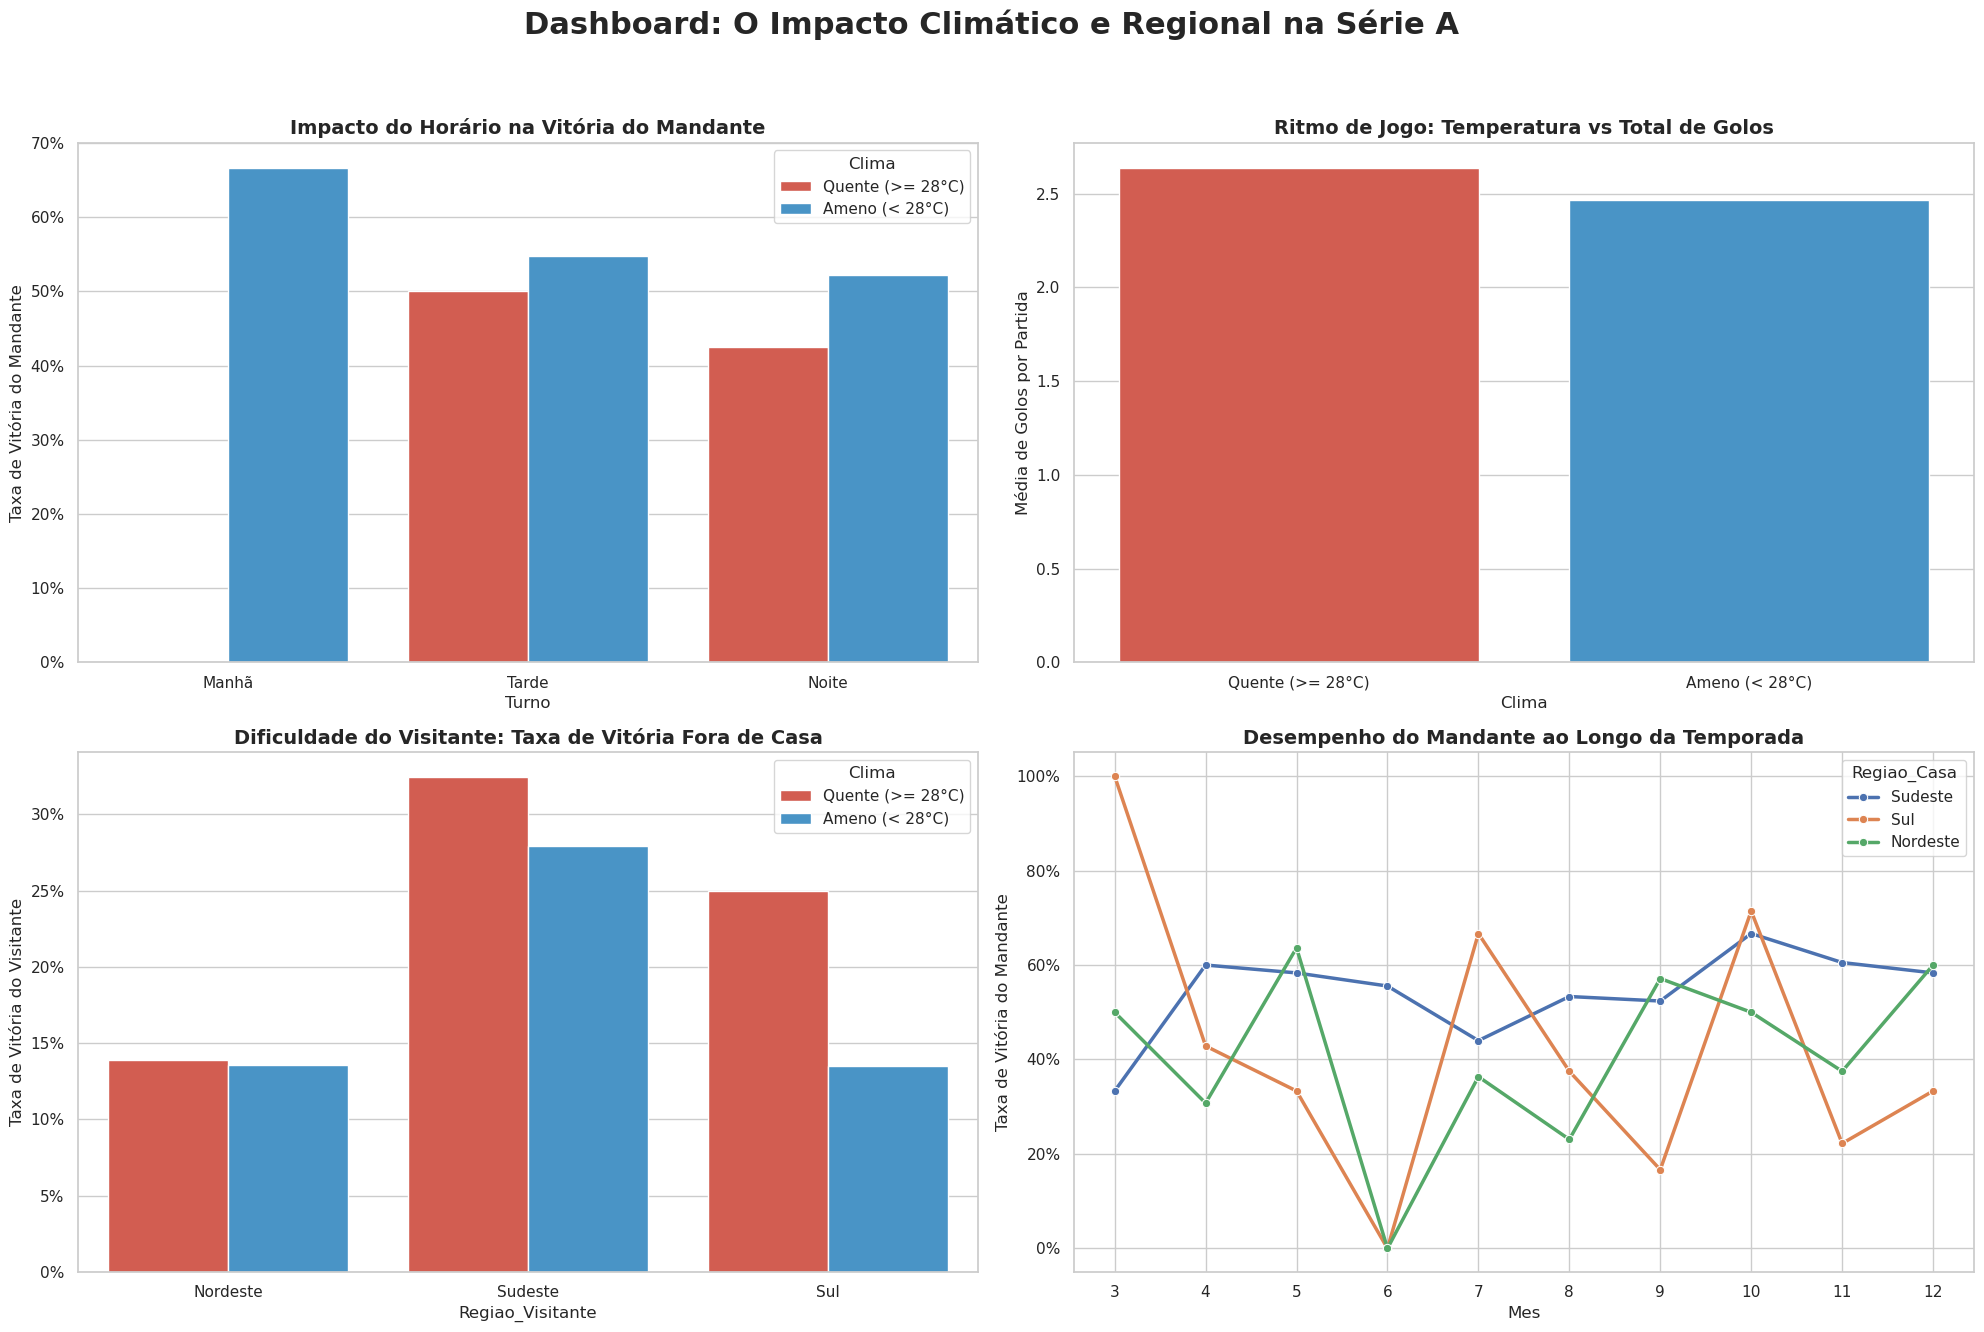

In [7]:
# ==========================================
# 5. ANÁLISE VISUAL E DASHBOARD
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Dashboard: O Impacto Climático e Regional na Série A', fontsize=22, fontweight='bold', y=0.98)
cores_clima = {'Quente (>= 28°C)': '#e74c3c', 'Ameno (< 28°C)': '#3498db'}

# Gráfico 1: Impacto do Horário
sns.barplot(data=df_jogos, x='Turno', y='Vitoria_Casa', hue='Clima', palette=cores_clima, ax=axes[0, 0], order=['Manhã', 'Tarde', 'Noite'], errorbar=None)
axes[0, 0].set_title('Impacto do Horário na Vitória do Mandante', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Taxa de Vitória do Mandante', fontsize=12)
axes[0, 0].set_yticklabels([f'{int(y*100)}%' for y in axes[0, 0].get_yticks()])

# Gráfico 2: Ritmo de Jogo (Total de Golos)
sns.barplot(data=df_jogos, x='Clima', y='Total_Gols', palette=cores_clima, ax=axes[0, 1], errorbar=None)
axes[0, 1].set_title('Ritmo de Jogo: Temperatura vs Total de Golos', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Média de Golos por Partida', fontsize=12)

# Gráfico 3: Desempenho do Visitante por Região
sns.barplot(data=df_jogos, x='Regiao_Visitante', y='Vitoria_Visitante', hue='Clima', palette=cores_clima, ax=axes[1, 0], errorbar=None)
axes[1, 0].set_title('Dificuldade do Visitante: Taxa de Vitória Fora de Casa', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Taxa de Vitória do Visitante', fontsize=12)
axes[1, 0].set_yticklabels([f'{int(y*100)}%' for y in axes[1, 0].get_yticks()])

# Gráfico 4: Evolução Mensal do Mandante
df_linha = df_jogos.dropna(subset=['Mes'])
sns.lineplot(data=df_linha, x='Mes', y='Vitoria_Casa', hue='Regiao_Casa', marker='o', linewidth=2.5, ax=axes[1, 1], errorbar=None)
axes[1, 1].set_title('Desempenho do Mandante ao Longo da Temporada', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Taxa de Vitória do Mandante', fontsize=12)
axes[1, 1].set_xticks(range(int(df_linha['Mes'].min()), int(df_linha['Mes'].max()) + 1))
axes[1, 1].set_yticklabels([f'{int(y*100)}%' for y in axes[1, 1].get_yticks()])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Salvar o ficheiro para não ter de processar tudo de novo amanhã
df_jogos.to_csv('base_brasileirao_enriquecida.csv', index=False)


🏆 ESTATÍSTICAS DE ZEBRAS NO CAMPEONATO 🏆
---------------------------------------------------------------------------
🦓 O Mandante Surpreende: Em 48 jogos, um mandante venceu um time 5+ posições ACIMA dele.
🚀 O Visitante Implacável: Em 13 jogos, o visitante venceu o mandante que estava 5+ posições ACIMA.
---------------------------------------------------------------------------


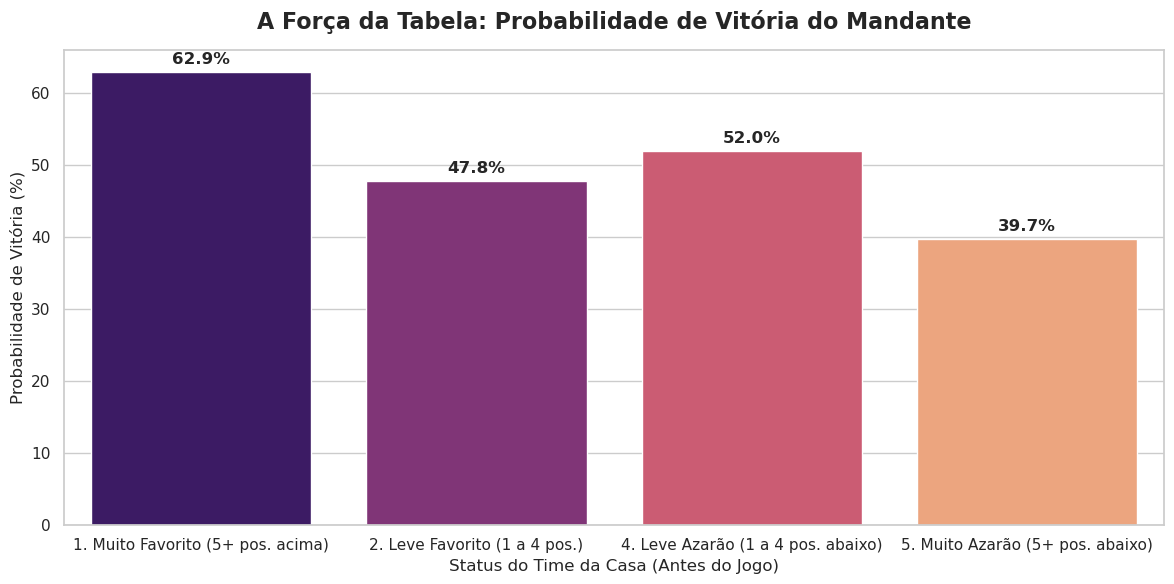

In [12]:
# ==========================================
# 6. ANÁLISE ESTATÍSTICA: PROBABILIDADES E ZEBRAS
# ==========================================

# 6.1 Classificando o Favoritismo do Mandante
# Lembrete: Diferença Positiva = Mandante está pior na tabela (é o Azarão)
def classificar_favoritismo(dif):
    if pd.isna(dif): return '0. Sem Histórico'
    if dif <= -5: return '1. Muito Favorito (5+ pos. acima)'
    if -4 <= dif <= -1: return '2. Leve Favorito (1 a 4 pos.)'
    if dif == 0: return '3. Confronto Direto (Mesma pos.)'
    if 1 <= dif <= 4: return '4. Leve Azarão (1 a 4 pos. abaixo)'
    if dif >= 5: return '5. Muito Azarão (5+ pos. abaixo)'

df_jogos['Status_Mandante'] = df_jogos['Diferenca_Posicao'].apply(classificar_favoritismo)

# 6.2 Calculando as Zebras
jogos_validos = df_jogos.dropna(subset=['Diferenca_Posicao'])

# Zebra do Mandante: Mandante venceu E estava 5 ou mais posições ABAIXO na tabela (Diferença >= 5)
zebras_mandante = len(jogos_validos[(jogos_validos['Diferenca_Posicao'] >= 5) & (jogos_validos['Vitoria_Casa'] == 1)])

# Zebra do Visitante: Visitante venceu E estava 5 ou mais posições ABAIXO do mandante (Diferença <= -5)
zebras_visitante = len(jogos_validos[(jogos_validos['Diferenca_Posicao'] <= -5) & (jogos_validos['Vitoria_Visitante'] == 1)])

print("\n ESTATÍSTICAS DE ZEBRAS NO CAMPEONATO 🏆")
print("-" * 75)
print(f"O Mandante Surpreende: Em {zebras_mandante} jogos, um mandante venceu um time 5+ posições ACIMA dele.")
print(f"O Visitante Implacável: Em {zebras_visitante} jogos, o visitante venceu o mandante que estava 5+ posições ACIMA.")
print("-" * 75)

# 6.3 Gráfico de Probabilidade Baseado na Tabela
# Calcula a % de vitórias em casa agrupado pelo status de favoritismo
taxa_vitoria_status = df_jogos.groupby('Status_Mandante')['Vitoria_Casa'].apply(lambda x: x.mean() * 100).reset_index()

# Removendo jogos sem histórico (Rodada 1) para não sujar o gráfico
taxa_vitoria_status = taxa_vitoria_status[taxa_vitoria_status['Status_Mandante'] != '0. Sem Histórico']

plt.figure(figsize=(12, 6))
grafico_prob = sns.barplot(
    data=taxa_vitoria_status, 
    x='Status_Mandante', 
    y='Vitoria_Casa', 
    palette='magma' # Paleta que vai do escuro (favorito) ao claro (azarão)
)

plt.title('A Força da Tabela: Probabilidade de Vitória do Mandante', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Status do Time da Casa (Antes do Jogo)', fontsize=12)
plt.ylabel('Probabilidade de Vitória (%)', fontsize=12)

# Adicionando os números exatos nas barras
for p in grafico_prob.patches:
    altura = p.get_height()
    if pd.notna(altura) and altura > 0:
        grafico_prob.annotate(format(altura, '.1f') + '%', 
                       (p.get_x() + p.get_width() / 2., altura), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()